In [1]:
import requests
from tqdm import tqdm
from os.path import join as oj
import numpy
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import data
import pickle as pkl
from skimage.util import img_as_float
import h5py
from copy import deepcopy
from skimage.filters import gabor_kernel
import gabor_feats
from scipy.io import loadmat
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
# plt.style.use('dark_background')
from run import *
out_dir = '/scratch/users/vision/data/gallant/vim_2_crcns'
save_dir = '../results'

# look at model fits

In [2]:
rois = ['v1lh', 'v1rh', 'v2lh', 'v2rh', 'v4lh', 'v4rh']
save_dir = oj(out_dir, 'mar3_1')
fnames = sorted([fname for fname in os.listdir(save_dir)])
results_list = [pd.Series(pkl.load(open(oj(save_dir, fname), "rb"))) for fname in tqdm(fnames) ]
results = pd.concat(results_list, axis=1).T.infer_objects()
results['region'] = results['roi'].str.slice(0, 2)
r = results.drop('model', axis=1) # drop model to speed things up

# sigmas are the standard deviations
sigmas = load_h5(oj(out_dir, f'out_rva_sigmas.h5'))
r['sigmas'] = sigmas[r.idx]

# alphas are the singular values
(U, alphas, Vt) = pkl.load(open(oj(out_dir, f'decomp_mot_energy.pkl'), 'rb'))

  0%|          | 0/867 [00:00<?, ?it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RidgeCV from version 0.22 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
100%|██████████| 867/867 [00:12<00:00, 71.48it/s]


In [3]:
r = results
r.keys()

Index(['roi', 'model', 'term1', 'term2', 'term3', 'term4', 'complexity1',
       'complexity2', 'snr', 'lambda_best', 'n_train', 'n_test', 'd', 'y_norm',
       'mse_train', 'r2_train', 'mse_test', 'r2_test', 'corr_test', 'idx',
       'region'],
      dtype='object')

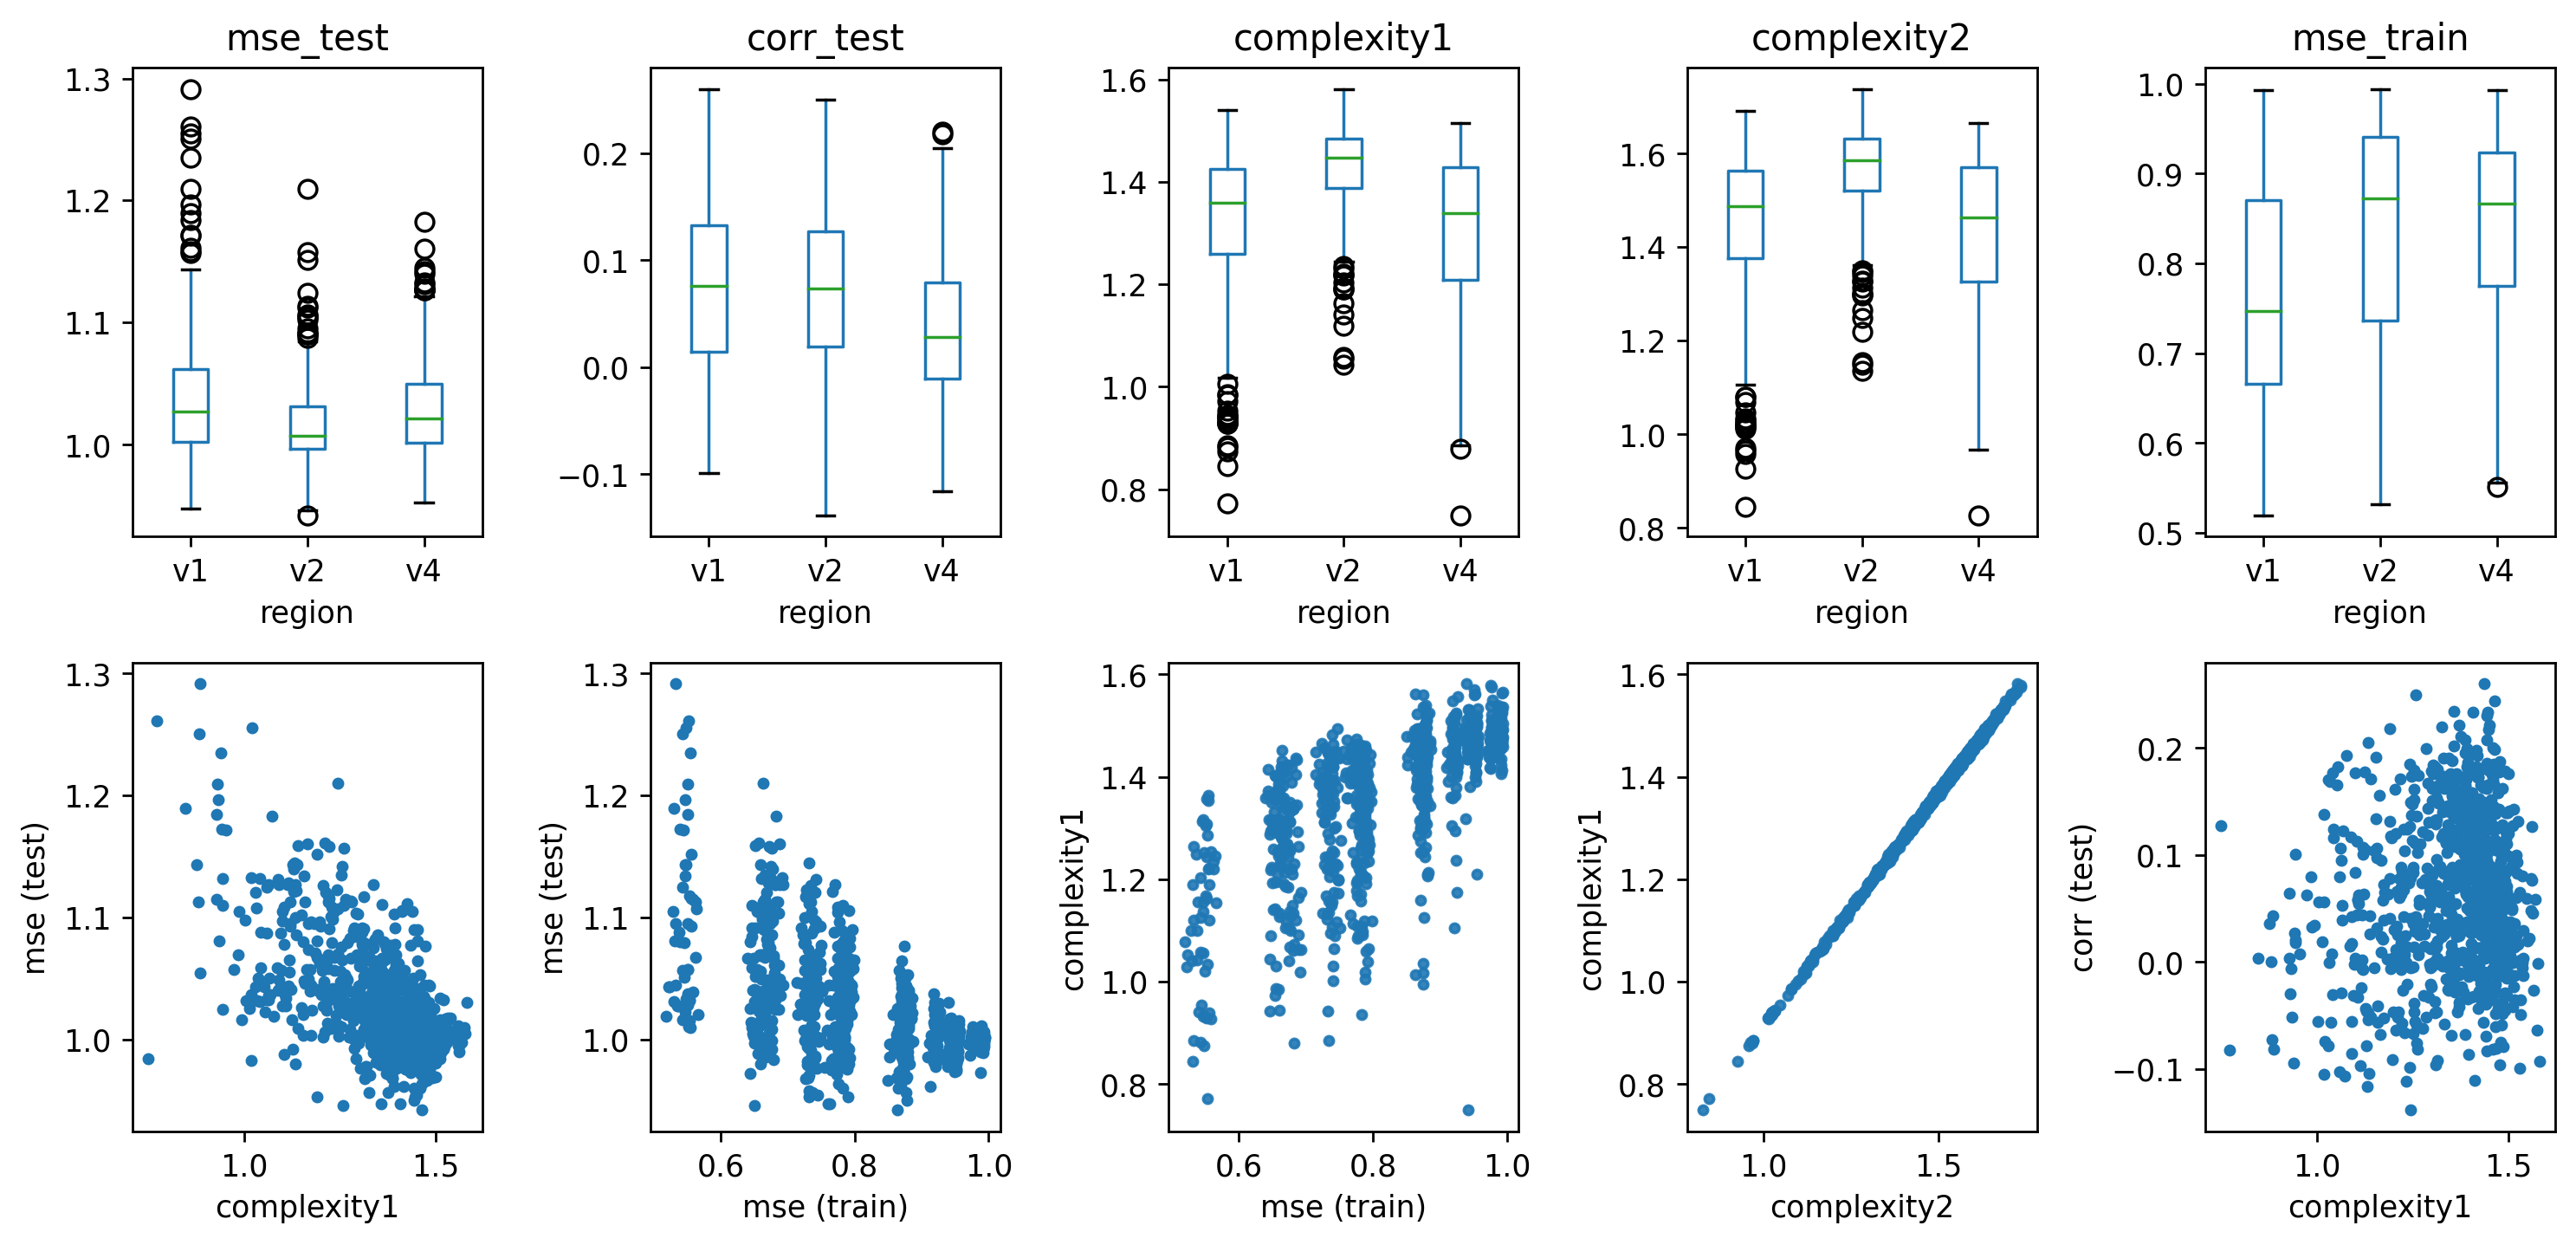

In [4]:
cols = ['mse_test', 'corr_test', 'complexity1', 'complexity2', 'mse_train']
f, axes = plt.subplots(2, 5, figsize=(12, 6), dpi=250)
axes = axes.flatten()
for i, col in enumerate(cols):
    # plt.subplot(R, C, 1)
    r.boxplot(by='region', column=col, ax=axes[i], grid=False)

ax = axes[i + 1]
ax.plot(r['complexity1'], r['mse_test'], '.')
ax.set_xlabel('complexity1')
ax.set_ylabel('mse (test)')
i += 1

ax = axes[i + 1]
ax.plot(r['mse_train'], r['mse_test'], '.')
ax.set_xlabel('mse (train)')
ax.set_ylabel('mse (test)')
i += 1

ax = axes[i + 1]
ax.plot(r['mse_train'], r['complexity1'], '.', alpha=0.9)
ax.set_xlabel('mse (train)')
ax.set_ylabel('complexity1')
i += 1

ax = axes[i + 1]
ax.plot(r['complexity2'], r['complexity1'], '.', alpha=0.9)
ax.set_xlabel('complexity2')
ax.set_ylabel('complexity1')
i += 1

ax = axes[i + 1]
ax.plot(r['complexity1'], r['corr_test'], '.')
ax.set_xlabel('complexity1')
ax.set_ylabel('corr (test)')
i += 1

plt.suptitle('')
plt.tight_layout()
plt.show()

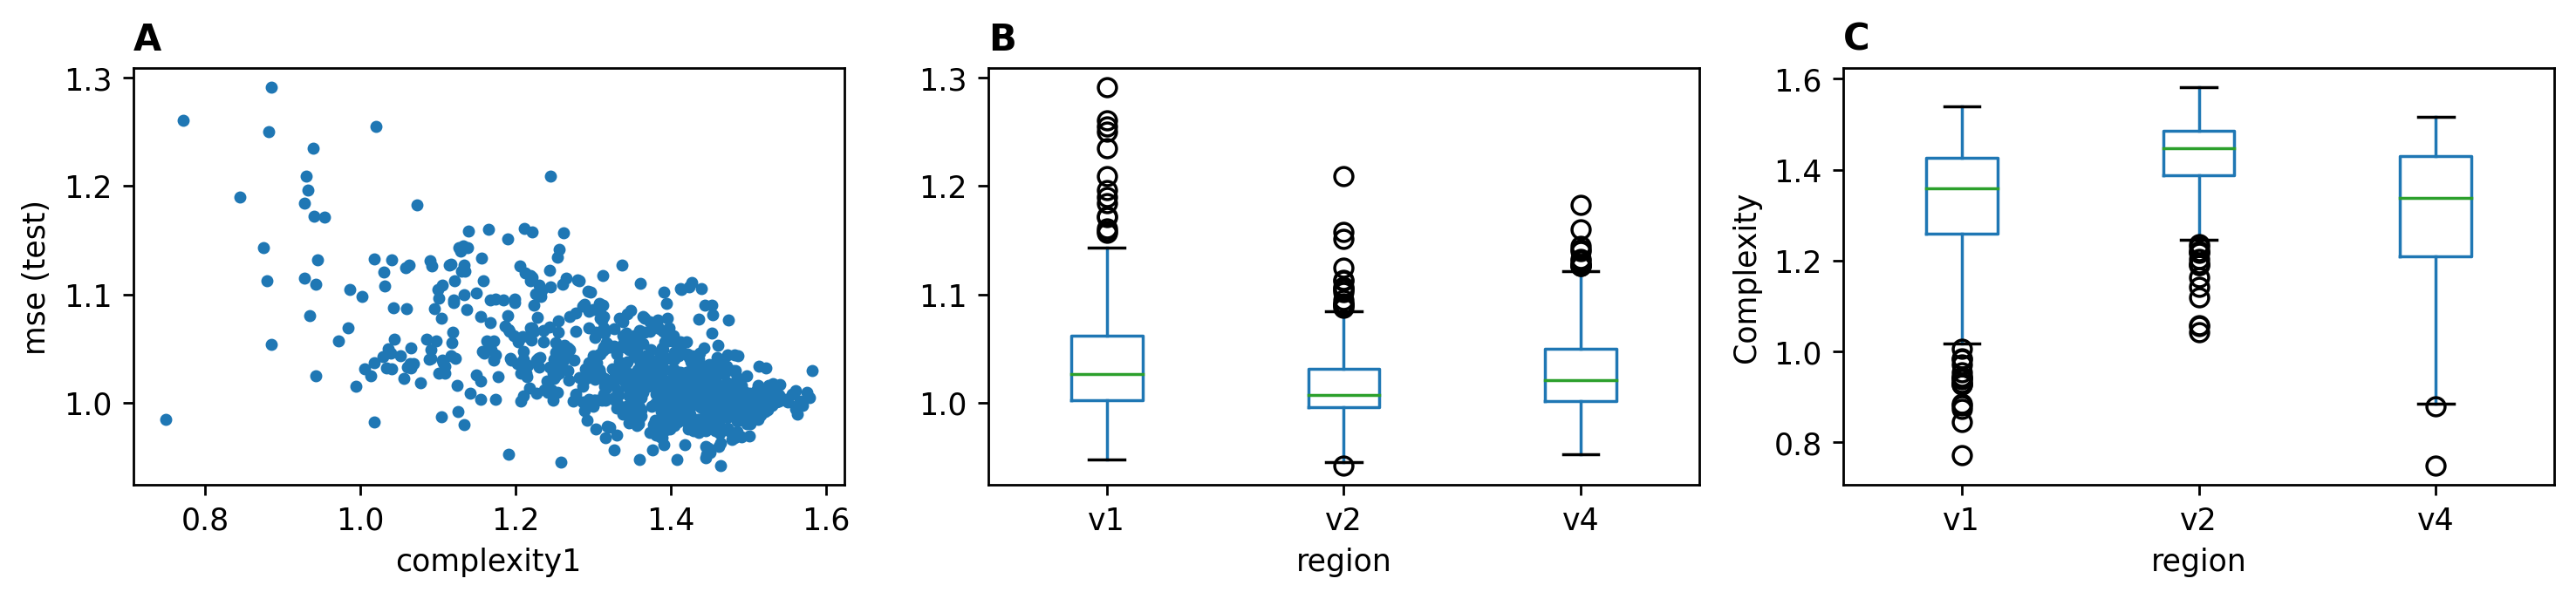

In [5]:
cols = ['mse_test', 'corr_test', 'complexity1', 'complexity2', 'mse_train']
lets = ['A', 'B', 'C', 'D', 'E']

f, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=250)
axes = axes.flatten()
# for i, col in enumerate(['mse_test', ]):
    # plt.subplot(R, C, 1)
i = 0
ax = axes[i]
ax.plot(r['complexity1'], r['mse_test'], '.')
ax.set_title(lets[i], fontweight='bold', loc='left')    
ax.set_xlabel('complexity1')
ax.set_ylabel('mse (test)')
i += 1

ax = axes[i]
r.boxplot(by='region', column='mse_test', ax=axes[i], grid=False)
ax.set_title(lets[i], fontweight='bold', loc='left')    
ax.set_title('')
plt.ylabel('Mean-squared error (test)')
i += 1

ax = axes[i]
r.boxplot(by='region', column='complexity1', ax=axes[i], grid=False)
ax.set_title(lets[i], fontweight='bold', loc='left')    
ax.set_title('')
plt.ylabel('Complexity')
i += 1



'''
ax = axes[i + 1]
ax.plot(r['complexity1'], r['corr_test'], '.')
ax.set_xlabel('complexity1')
ax.set_ylabel('corr (test)')
i += 1
'''

plt.suptitle('')
plt.tight_layout()
plt.savefig(oj(save_dir, 'fig_fmri.pdf'))

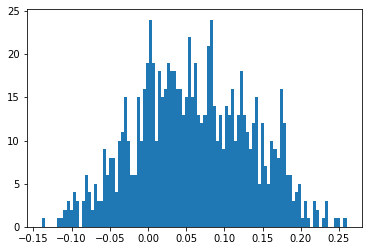

In [6]:
plt.hist(r['corr_test'], bins=100)
plt.show()

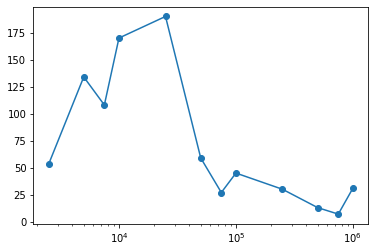

In [7]:
lambdas, counts = np.unique(r.lambda_best, return_counts=True)
plt.plot(lambdas, counts, 'o-')
plt.xscale('log')

# basic viz

In [17]:
idxs = r.idx.values
vals = r.complexity1
vol = np.zeros(73728) * np.nan
vol[idxs] = vals
vol = vol.reshape(18, 64, 64)
vol = vol.transpose()

In [18]:
print(vol.shape, np.nansum(vol), np.nansum(np.nansum(vol, axis=0), axis=0), np.nanmin(vol), np.nanmax(vol))

(64, 64, 18) 1196.9538941802846 [  0.          94.12762267 134.88365408 170.73218268 212.45932836
 202.32424764 143.59042676 147.274676    67.84258973  23.71916627
   0.           0.           0.           0.           0.
   0.           0.           0.        ] 0.7488806184282123 1.5814919336264228


/accounts/projects/vision/.local/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/accounts/projects/vision/.local/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/accounts/projects/vision/.local/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/accounts/projects/vision/.local/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/accounts/projects/vision/.local/lib/python3.7/site-packages/matplotlib/colors.py:933: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/accounts/projects/vision/.local/lib/python3.7/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a 

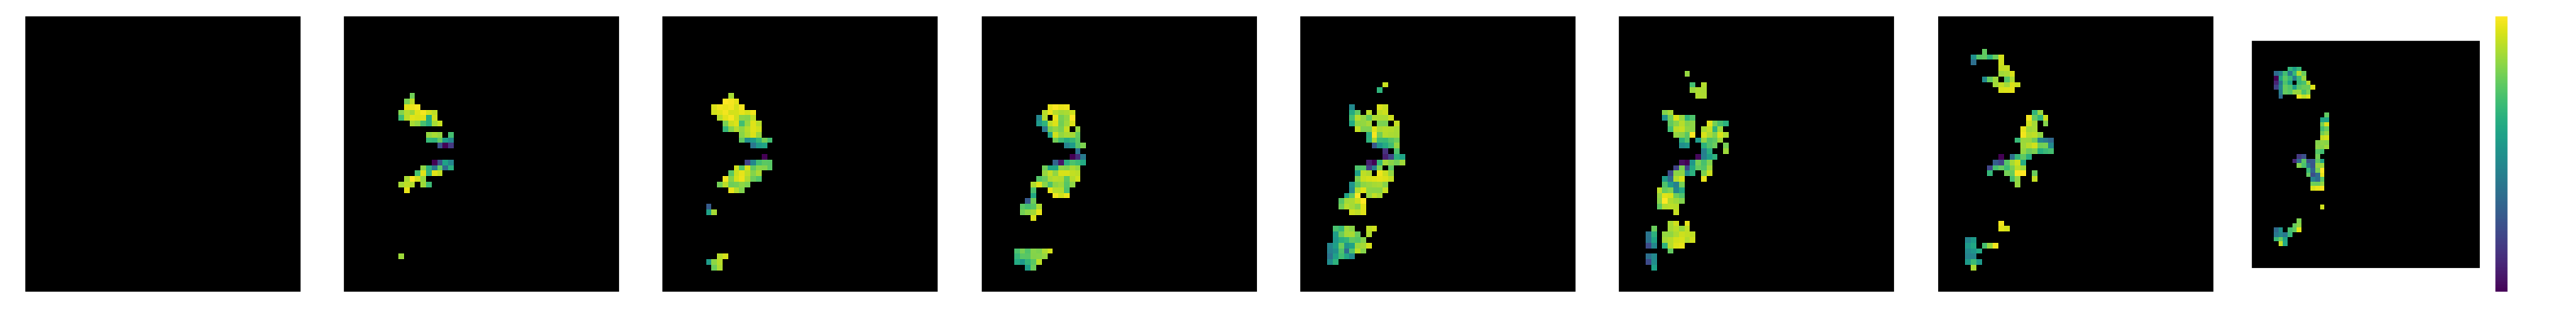

In [19]:
R, C = 1, 8
plt.figure(figsize=(C * 2, R * 2), dpi=200)
vmin = np.nanmin(vol)
vmax = np.nanmax(vol)
for i in range(8):
    plt.subplot(R, C, i + 1)
    NUM = 7
    plt.imshow(vol[NUM: -NUM, NUM: -NUM, i]) #, vmin=vmin, vmax=vmax)
    plt.yticks([])
    plt.xticks([])
plt.colorbar()
plt.tight_layout()
plt.show()
# plt.imshow(vol[:, :, 15])

(64, 64, 18, 3)


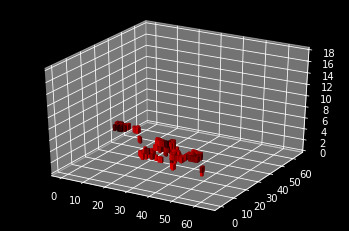

In [230]:
voxels = ~np.isnan(vol)
colors = vol
colors = (colors - np.nanmin(colors)) / (np.nanmax(colors) - np.nanmin(colors))
s = colors.shape
colors = colors.reshape((s[0], s[1], s[2], 1))
colors = colors.repeat(axis=-1, repeats=3)
colors[..., 1:] = 0
print(colors.shape)

# and plot everything
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(voxels, facecolors=colors) #, edgecolor='k')

plt.show()

# pycortex

- install pycortex by cloning and running python setup.py install
- the config file is located at `cortex.options.usercfg`
    - edit this file to change the default_filestore to cortex installation filestore/db folder
    - also edit it to change the colormaps to cortex installation filestore/colormaps folder
- install fsl: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSL
    - edit fsl_prefix in the config file based on what was installed
- need to make sure fsl can run properly: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FslInstallation/ShellSetup

In [1]:
import nibabel as nib
import cortex
# from cortex import surfs

'''
img = nib.load(anat_file)
im_np = np.array(img.get_fdata())
im_np.shape

anat_file = oj(out_dir, 'anatomy/S1_anatomy.nii')
ret_file = 'S1_retinotopy.hdf'
ds = cortex.load(ret_file)
'''

"\nimg = nib.load(anat_file)\nim_np = np.array(img.get_fdata())\nim_np.shape\n\nanat_file = oj(out_dir, 'anatomy/S1_anatomy.nii')\nret_file = 'S1_retinotopy.hdf'\nds = cortex.load(ret_file)\n"

In [2]:
cortex.options.usercfg

'/Users/chandan/Library/Application Support/pycortex/options.cfg'

In [ ]:
cortex.align.automatic('S1', 'example-transform', '../data/anatomy/S1_anatomy.nii')

In [ ]:
m = cortex.quickshow((np.random.randn(31, 100, 100), "S1", "fullhead"))

# nilearn plotting

In [40]:
x = np.random.randn(64, 64, 18)

In [41]:
from nilearn import plotting, datasets

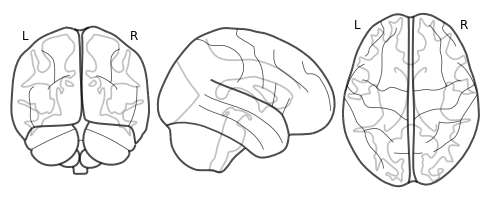

In [44]:
plotting.plot_glass_brain(None) #, annotate=False, black_bg=True)

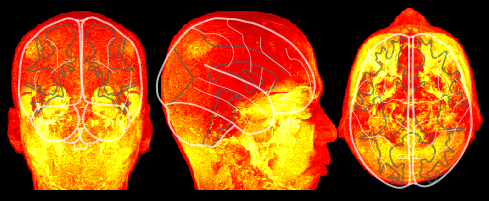

In [32]:
plotting.plot_glass_brain(anat_file, annotate=False, black_bg=True)

In [56]:
motor_images = datasets.fetch_neurovault_motor_task()
stat_img = motor_images.images[0]
# stat_img is just the name of the file that we downloded
stat_img


Dataset created in /accounts/projects/vision/nilearn_data/neurovault



'/accounts/projects/vision/nilearn_data/neurovault/collection_658/image_10426.nii.gz'